In [ ]:
import os
import numpy as np
import pickle
from PIL import Image
import matplotlib.pyplot as plt
from sklearn import tree
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

# https://www.kaggle.com/datasets/vaibhao/handwritten-characters


In [11]:

items = ['A', 'B']

len(items)

2

In [17]:
data_path="archive/Train"

items = ['0','1', '2','3','4','5','6','7','8','9']

number_of_items = 500

X = np.zeros((len(items)*100, 1024))
t = np.zeros((len(items)*100))
i = 0
p = 0

for j, item in enumerate(items):
    folder_path = data_path + "/" + item
    print(f'Loading Images "{item}" processing...')
    for file in sorted(os.listdir(folder_path)):
        file_path = folder_path + "/" + file
        image = Image.open(file_path)
        X[i,:] = np.array(image).flatten()
        t[i] = j
        i=+1

X.shape, t.shape

Loading Images "0" processing...


KeyboardInterrupt: 

In [66]:
len(['A','B','C','D','E','F','G','H','I'])

9

In [ ]:
from concurrent.futures import ThreadPoolExecutor
import os
import numpy as np
from PIL import Image

data_path = "archive/Train"
items = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','P','Q','R','R','S','T','U','V','W','X','Y','Z']
#items = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9','A','B']
number_of_items = 30000

X = np.zeros((len(items) * number_of_items, 1024))
t = np.zeros((len(items) * number_of_items))

def process_image(file_path, index, label):
    image = Image.open(file_path)
    return np.array(image).flatten(), index, label

with ThreadPoolExecutor() as executor:
    futures = []
    i = 0
    for j, item in enumerate(items):
        folder_path = os.path.join(data_path, item)
        print(f'Loading Images "{item}" processing...')
        for file in os.listdir(folder_path)[:number_of_items]:
            file_path = os.path.join(folder_path, file)
            futures.append(executor.submit(process_image, file_path, i, j))
            i += 1

    for future in futures:
        image_array, index, label = future.result()
        X[index, :] = image_array
        t[index] = label

print(X.shape, t.shape)


Loading Images "A" processing...
Loading Images "B" processing...
Loading Images "C" processing...
Loading Images "D" processing...
Loading Images "E" processing...
Loading Images "F" processing...
Loading Images "G" processing...
Loading Images "H" processing...
Loading Images "I" processing...
Loading Images "J" processing...
Loading Images "K" processing...
Loading Images "L" processing...
Loading Images "M" processing...
Loading Images "N" processing...
Loading Images "P" processing...
Loading Images "Q" processing...
Loading Images "R" processing...
Loading Images "R" processing...
Loading Images "S" processing...
Loading Images "T" processing...
Loading Images "U" processing...
Loading Images "V" processing...
Loading Images "W" processing...
Loading Images "X" processing...
Loading Images "Y" processing...
Loading Images "Z" processing...
(260000, 1024) (260000,)


In [16]:

def split_dataset_without_mixing(X, t, n):
    """
    Splits the dataset X and t into n parts while preserving the order.
    
    Parameters:
    - X: Feature dataset (numpy array).
    - t: Labels (numpy array).
    - n: Number of splits.
    
    Returns:
    - A tuple of lists: ([X1, X2, ...], [t1, t2, ...])
    """
    if len(X) != len(t):
        raise ValueError("X and t must have the same number of samples.")
    
    if len(X) % n != 0:
        raise ValueError("The dataset size must be divisible by n for equal splits.")
    
    split_size = len(X) // n
    X_splits = []
    t_splits = []
    
    for i in range(n):
        start = i * split_size
        end = start + split_size
        X_splits.append(X[start:end])
        t_splits.append(t[start:end])
    
    return X_splits, t_splits

# Beispiel: Splitte in 5 Teile
n_splits = 3
X_splits, t_splits = split_dataset_without_mixing(X, t, n_splits)

# Ausgabe der Ergebnisse
for i, (X_part, t_part) in enumerate(zip(X_splits, t_splits)):
    base_filename="dataset_split"
    print(f"Dataset {i+1}: X.shape = {X_part.shape}, t.shape = {t_part.shape}")
    filename = f"{base_filename}_{i+1}.pkl"
    with open(filename, "wb") as f:
        pickle.dump((X_part, t_part), f)
    print(f"Saved split {i+1} to {filename}")

Dataset 1: X.shape = (260000, 1024), t.shape = (260000,)
Saved split 1 to dataset_split_1.pkl
Dataset 2: X.shape = (260000, 1024), t.shape = (260000,)
Saved split 2 to dataset_split_2.pkl
Dataset 3: X.shape = (260000, 1024), t.shape = (260000,)
Saved split 3 to dataset_split_3.pkl


In [64]:
items[20]

'U'

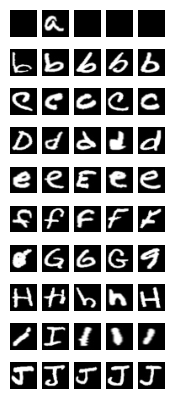

In [18]:
# displaying some examples of digits
plt.figure(figsize=(2,5))
grid_loc=1
for i in range(10):
    digits_labels_idx = np.where(t==i)[0]
    idx = np.random.randint(len(digits_labels_idx),size=5)
    for j in range(5):
        plt.subplot(10,5,grid_loc)
        plt.imshow(X[digits_labels_idx[idx[j]],:].reshape(32,32), cmap='gray')
        plt.axis('off')
        grid_loc+=1

In [19]:
X_train, X_test, t_train, t_test  = train_test_split(X, t, 
                                                     test_size=0.2,
                                                     shuffle=True, 
                                                     random_state=42, 
                                                     stratify=t)

In [30]:
pipeline = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('classifier', RandomForestClassifier(random_state=0))])

In [32]:
# Parameter Grid
param_grid = {
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [5,10,20,30,40],
    'classifier__min_samples_split': [2,4,6,8,10],
    'classifier__min_samples_leaf': [1,2,4]
}

# Optimized GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=KFold(n_splits=5, shuffle=True, random_state=0),
    scoring='neg_mean_squared_error',
    refit=True,
    n_jobs=-2  # Parallel processing
)

grid_search.fit(X_train,t_train) # use X_train instead of X_train_prepeard, since the Classifier pipline includes the preprocessing pipline 
best_model = grid_search.best_estimator_
grid_search.best_params_

/opt/miniconda3/envs/c_env/lib/python3.9/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


{'classifier__criterion': 'gini',
 'classifier__max_depth': 20,
 'classifier__min_samples_leaf': 1,
 'classifier__min_samples_split': 8}

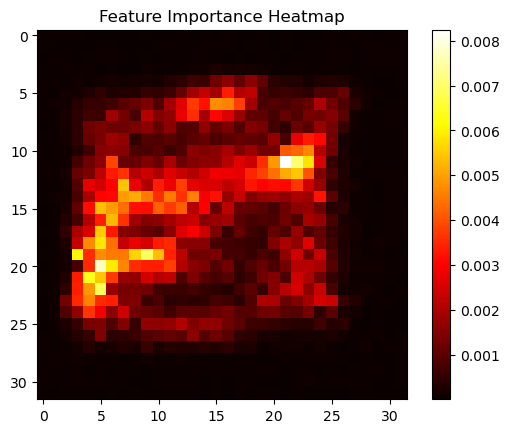

In [33]:
# Get feature importances from the best model
best_model = grid_search.best_estimator_.named_steps['classifier']
feature_importances = best_model.feature_importances_

# Reshape to 8x8 image
importances_image = feature_importances.reshape(32, 32)

# Display the image
plt.imshow(importances_image, cmap='hot', interpolation='nearest')
plt.title('Feature Importance Heatmap')
plt.colorbar()
plt.show()

In [34]:
y_train_predict = best_model.predict(X_train)
y_test_predict = best_model.predict(X_test)

In [35]:
# Accuracy
train_accuracy = accuracy_score(t_train, y_train_predict)
test_accuracy = accuracy_score(t_test, y_test_predict)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Training Accuracy: 0.5474
Test Accuracy: 0.5510


In [36]:
# Report performance on the training set
print('Training set performance:')
print(classification_report(t_train, y_train_predict))

Training set performance:
              precision    recall  f1-score   support

         0.0       0.67      0.99      0.80       800
         1.0       1.00      0.05      0.09       800
         2.0       0.90      0.76      0.82       800
         3.0       0.83      0.47      0.60       800
         4.0       0.94      0.61      0.74       800
         5.0       0.99      0.22      0.36       800
         6.0       0.97      0.70      0.81       800
         7.0       1.00      0.20      0.34       800
         8.0       0.22      0.98      0.37       800
         9.0       0.54      0.50      0.52       800

    accuracy                           0.55      8000
   macro avg       0.81      0.55      0.54      8000
weighted avg       0.81      0.55      0.54      8000



In [27]:
# Report performance on the test set
print('Training set performance:')
print(classification_report(t_test, y_test_predict))

Training set performance:
              precision    recall  f1-score   support

         0.0       0.65      0.98      0.78       100
         1.0       1.00      0.05      0.10       100
         2.0       0.96      0.68      0.80       100
         3.0       0.82      0.50      0.62       100
         4.0       0.94      0.46      0.62       100
         5.0       1.00      0.31      0.47       100
         6.0       0.92      0.73      0.82       100
         7.0       0.96      0.26      0.41       100
         8.0       0.21      0.93      0.35       100
         9.0       0.54      0.48      0.51       100

    accuracy                           0.54      1000
   macro avg       0.80      0.54      0.55      1000
weighted avg       0.80      0.54      0.55      1000



In [37]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split

# Normalize pixel values to [0, 1]
X = X / 255.0

# Reshape the data to include the channel dimension (32x32x1 for grayscale images)
X = X.reshape(-1, 32, 32, 1)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, t, test_size=0.2, random_state=42)

# Convert labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')  # 10 classes for digits 0-9
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc:.2f}")

# Save the model for future use
model.save("digit_classifier.h5")


2024-12-01 12:49:39.953669: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10


/opt/miniconda3/envs/c_env/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.6003 - loss: 1.1639 - val_accuracy: 0.9644 - val_loss: 0.1329
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.9367 - loss: 0.2092 - val_accuracy: 0.9688 - val_loss: 0.1063
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9537 - loss: 0.1510 - val_accuracy: 0.9844 - val_loss: 0.0761
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.9621 - loss: 0.1066 - val_accuracy: 0.9869 - val_loss: 0.0643
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.9752 - loss: 0.0782 - val_accuracy: 0.9806 - val_loss: 0.0778
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.9750 - loss: 0.0739 - val_accuracy: 0.9819 - val_loss: 0.0682
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.9838 - loss: 0.0607 - val_accuracy: 0.9881 - val_loss: 0.0648
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.9848 - loss: 0.0494 - val_accuracy: 0.986

Test accuracy: 0.98


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


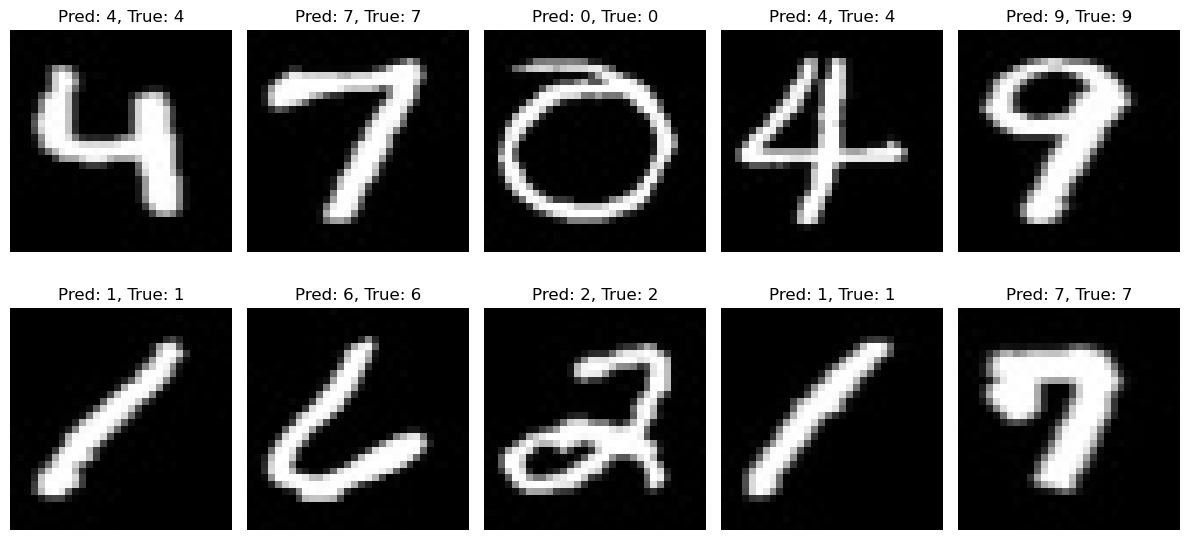

In [38]:
import matplotlib.pyplot as plt
import random

# Load the trained model
model = tf.keras.models.load_model("digit_classifier.h5")

# Select 10 random indices from the test set
random_indices = random.sample(range(X_test.shape[0]), 10)

# Prepare the selected images and their true labels
random_images = X_test[random_indices]
true_labels = y_test[random_indices]

# Predict using the model
predictions = model.predict(random_images)
predicted_labels = tf.argmax(predictions, axis=1)

# Plot the images along with their predictions
plt.figure(figsize=(12, 6))
for i, (image, pred_label, true_label) in enumerate(zip(random_images, predicted_labels, true_labels)):
    plt.subplot(2, 5, i + 1)
    plt.imshow(image.squeeze(), cmap='gray')  # Remove channel dimension and display in grayscale
    plt.title(f"Pred: {pred_label.numpy()}, True: {tf.argmax(true_label).numpy()}")
    plt.axis('off')

plt.tight_layout()
plt.show()


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


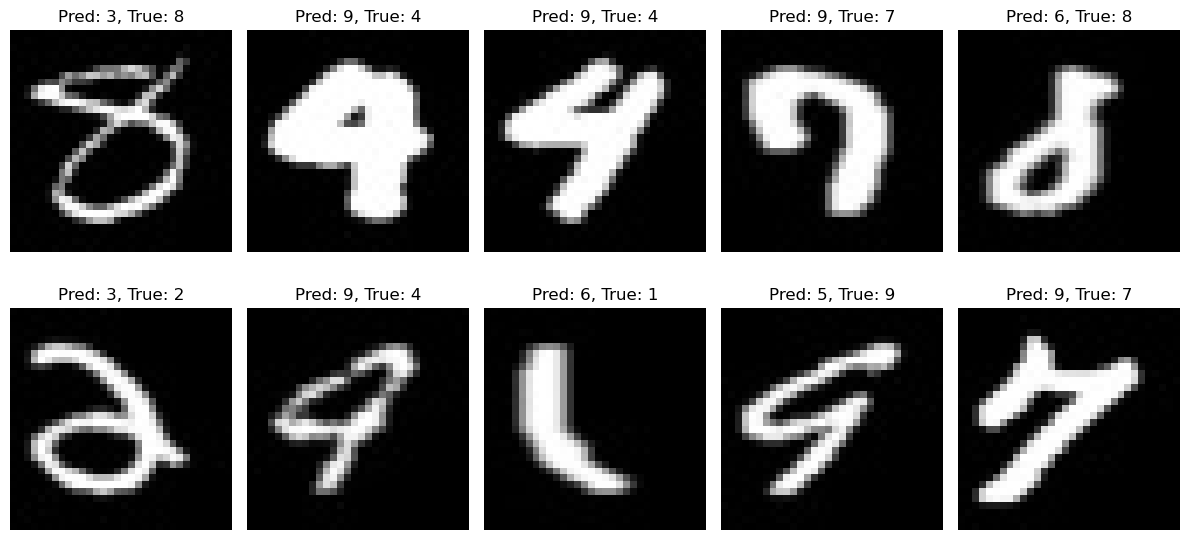

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# Predict the entire test set
predictions = model.predict(X_test)
predicted_labels = tf.argmax(predictions, axis=1).numpy()
true_labels = tf.argmax(y_test, axis=1).numpy()

# Find indices of misclassified samples
misclassified_indices = np.where(predicted_labels != true_labels)[0]

# If there are misclassified samples, display them
if len(misclassified_indices) > 0:
    # Select up to 10 misclassified samples for visualization
    sample_indices = random.sample(list(misclassified_indices), min(10, len(misclassified_indices)))

    # Plot the misclassified samples
    plt.figure(figsize=(12, 6))
    for i, idx in enumerate(sample_indices):
        image = X_test[idx].squeeze()  # Remove channel dimension
        pred_label = predicted_labels[idx]
        true_label = true_labels[idx]

        plt.subplot(2, 5, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"Pred: {pred_label}, True: {true_label}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No misclassified samples found!")


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam


# Normalize the data
X = X / 255.0

# Reshape the data to include the channel dimension (32x32x1 for grayscale images)
X = X.reshape(-1, 32, 32, 1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, t, test_size=0.2, random_state=42)

# Convert labels to one-hot encoding (35 classes: 0-9, A-Z excluding 'O')
num_classes = 26
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# Define the CNN model with adjusted architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),  # Additional dense layer
    Dense(num_classes, activation='softmax')  # 36 classes
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc:.2f}")

# Save the model for future use
model.save("digit_classifier.h5")


2024-12-01 15:20:15.142258: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/miniconda3/envs/c_env/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
5200/5200 ━━━━━━━━━━━━━━━━━━━━ 143s 27ms/step - accuracy: 0.7466 - loss: 0.8013 - val_accuracy: 0.9071 - val_loss: 0.2197
Epoch 2/30
5200/5200 ━━━━━━━━━━━━━━━━━━━━ 134s 26ms/step - accuracy: 0.8968 - loss: 0.2627 - val_accuracy: 0.9089 - val_loss: 0.2098
Epoch 3/30
5200/5200 ━━━━━━━━━━━━━━━━━━━━ 136s 26ms/step - accuracy: 0.9055 - loss: 0.2296 - val_accuracy: 0.9149 - val_loss: 0.1920
Epoch 4/30
5200/5200 ━━━━━━━━━━━━━━━━━━━━ 134s 26ms/step - accuracy: 0.9100 - loss: 0.2125 - val_accuracy: 0.9159 - val_loss: 0.1911
Epoch 5/30
5200/5200 ━━━━━━━━━━━━━━━━━━━━ 129s 25ms/step - accuracy: 0.9143 - loss: 0.2017 - val_accuracy: 0.9168 - val_loss: 0.1870
Epoch 6/30
5200/5200 ━━━━━━━━━━━━━━━━━━━━ 125s 24ms/step - accuracy: 0.9172 - loss: 0.1873 - val_accuracy: 0.9162 - val_loss: 0.1873
Epoch 7/30
5200/5200 ━━━━━━━━━━━━━━━━━━━━ 124s 24ms/step - accuracy: 0.9200 - loss: 0.1810 - val_accuracy: 0.9181 - val_loss: 0.1853
Epoch 8/30
5200/5200 ━━━━━━━━━━━━━━━━━━━━ 124s 24ms/step - accuracy: 

Test accuracy: 0.92


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam



for 

    # Normalize the data
    X = X / 255.0

    # Reshape the data to include the channel dimension (32x32x1 for grayscale images)
    X = X.reshape(-1, 32, 32, 1)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, t, test_size=0.2, random_state=42)

    # Convert labels to one-hot encoding (35 classes: 0-9, A-Z excluding 'O')
    num_classes = 26
    y_train = to_categorical(y_train, num_classes)
    y_test = to_categorical(y_test, num_classes)

    # Define the CNN model with adjusted architecture
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),  # Additional dense layer
        Dense(num_classes, activation='softmax')  # 36 classes
    ])

    # Compile the model
    model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2)

    # Evaluate the model
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print(f"Test accuracy: {test_acc:.2f}")

    # Save the model for future use
    model.save("digit_classifier.h5")

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam


# Normalize the data
X = X / 255.0

# Reshape the data to include the channel dimension (32x32x1 for grayscale images)
X = X.reshape(-1, 32, 32, 1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, t, test_size=0.2, random_state=42)

# Convert labels to one-hot encoding (35 classes: 0-9, A-Z excluding 'O')
num_classes = 26
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# Create an ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,        # Random rotations
    width_shift_range=0.2,    # Horizontal shift
    height_shift_range=0.2,   # Vertical shift
    shear_range=0.2,          # Random shear
    zoom_range=0.2,           # Random zoom
    horizontal_flip=True,     # Random horizontal flip
    fill_mode='nearest'       # Fill missing pixels with the nearest value
)

# Fit the generator on the training data
datagen.fit(X_train)

# Define the CNN model with adjusted architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),  # Additional dense layer
    Dense(num_classes, activation='softmax')  # 36 classes
])

# Compile the model with an adjusted learning rate using the Adam optimizer
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Add early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with augmented data
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    epochs=30,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])


# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc:.2f}")

# Save the model
model.save("alphanumeric_classifier.h5")


2024-12-01 15:07:41.379146: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/miniconda3/envs/c_env/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30


/opt/miniconda3/envs/c_env/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9750/9750 ━━━━━━━━━━━━━━━━━━━━ 292s 30ms/step - accuracy: 0.5808 - loss: 1.3387 - val_accuracy: 0.8284 - val_loss: 0.4628
Epoch 2/30
 198/9750 ━━━━━━━━━━━━━━━━━━━━ 4:35 29ms/step - accuracy: 0.7645 - loss: 0.6803

KeyboardInterrupt: 

1625/1625 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step


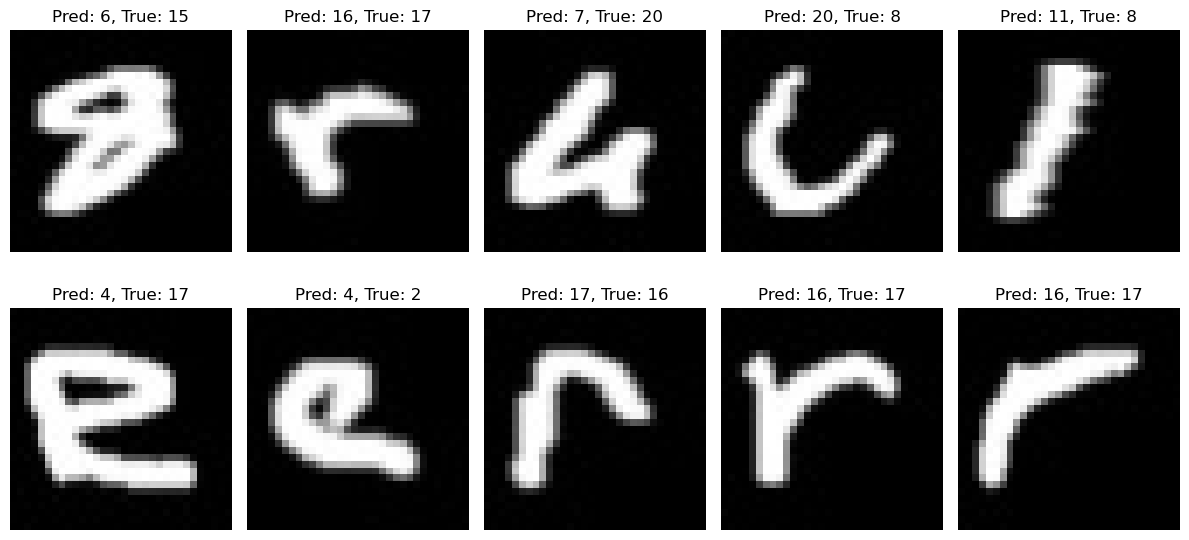

In [6]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Predict the entire test set
predictions = model.predict(X_test)
predicted_labels = tf.argmax(predictions, axis=1).numpy()
true_labels = tf.argmax(y_test, axis=1).numpy()

# Find indices of misclassified samples
misclassified_indices = np.where(predicted_labels != true_labels)[0]

# If there are misclassified samples, display them
if len(misclassified_indices) > 0:
    # Select up to 10 misclassified samples for visualization
    sample_indices = random.sample(list(misclassified_indices), min(10, len(misclassified_indices)))

    # Plot the misclassified samples
    plt.figure(figsize=(12, 6))
    for i, idx in enumerate(sample_indices):
        image = X_test[idx].squeeze()  # Remove channel dimension
        pred_label = predicted_labels[idx]
        true_label = true_labels[idx]

        plt.subplot(2, 5, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"Pred: {pred_label}, True: {true_label}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No misclassified samples found!")

/opt/miniconda3/envs/c_env/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
   3/2700 ━━━━━━━━━━━━━━━━━━━━ 1:25 32ms/step - accuracy: 0.0191 - loss: 3.5834 

/opt/miniconda3/envs/c_env/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2700/2700 ━━━━━━━━━━━━━━━━━━━━ 74s 27ms/step - accuracy: 0.0274 - loss: 3.5840 - val_accuracy: 0.0254 - val_loss: 3.5838 - learning_rate: 0.0010
Epoch 2/15
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 74s 27ms/step - accuracy: 0.0269 - loss: 3.5837 - val_accuracy: 0.0272 - val_loss: 3.5839 - learning_rate: 0.0010
Epoch 3/15
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 72s 27ms/step - accuracy: 0.0279 - loss: 3.5838 - val_accuracy: 0.0264 - val_loss: 3.5839 - learning_rate: 0.0010
Epoch 4/15
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 72s 27ms/step - accuracy: 0.0275 - loss: 3.5839 - val_accuracy: 0.0272 - val_loss: 3.5839 - learning_rate: 0.0010
675/675 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step


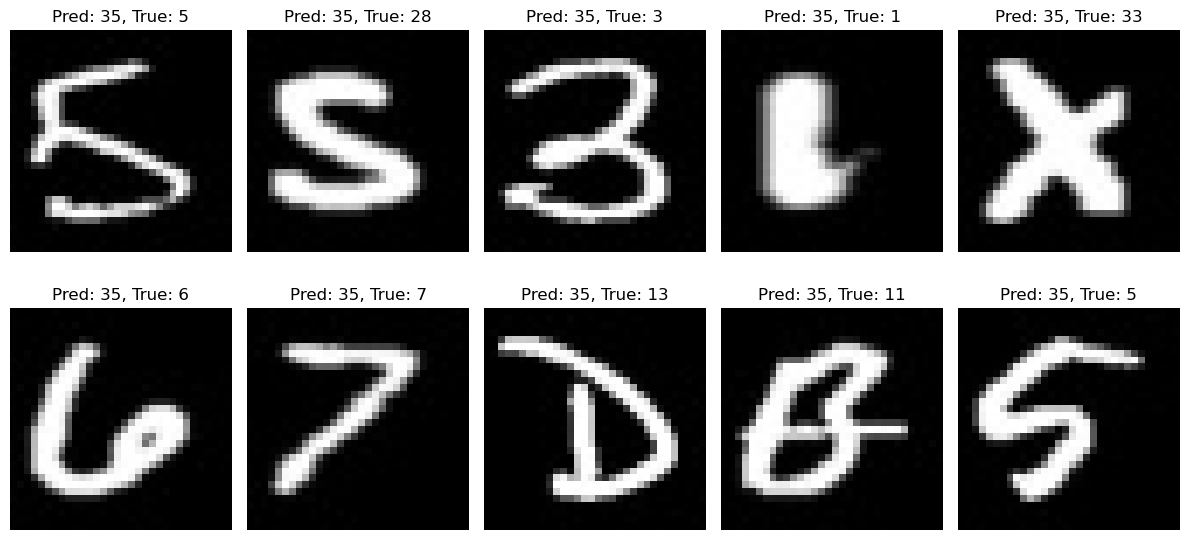

In [53]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight

# Normalize the data
X = X / 255.0

# Reshape the data to include the channel dimension (32x32x1 for grayscale images)
X = X.reshape(-1, 32, 32, 1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, t, test_size=0.2, random_state=42)

# Convert labels to one-hot encoding (36 classes: 0-9, A-Z excluding 'O')
num_classes = 36
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# Compute class weights to handle class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(t), y=t)
class_weight_dict = dict(enumerate(class_weights))

# Create an ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,        # Random rotations
    width_shift_range=0.2,    # Horizontal shift
    height_shift_range=0.2,   # Vertical shift
    shear_range=0.2,          # Random shear
    zoom_range=0.2,           # Random zoom
    horizontal_flip=True,     # Random horizontal flip
    fill_mode='nearest'       # Fill missing pixels with the nearest value
)

# Fit the generator on the training data
datagen.fit(X_train)

# Define the CNN model with adjusted architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),  # Additional dense layer
    Dense(num_classes, activation='softmax')  # 36 classes
])

# Compile the model with an adjusted learning rate using the Adam optimizer
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Add early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Define a learning rate scheduler
def scheduler(epoch, lr):
    if epoch % 5 == 0 and epoch > 0:
        return lr * 0.1
    return lr

lr_scheduler = LearningRateScheduler(scheduler)

# Train the model with augmented data
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    epochs=15,
                    validation_data=(X_test, y_test),
                    class_weight=class_weight_dict,
                    callbacks=[early_stopping, lr_scheduler])

# Predict the entire test set
predictions = model.predict(X_test)
predicted_labels = tf.argmax(predictions, axis=1).numpy()
true_labels = tf.argmax(y_test, axis=1).numpy()

# Find indices of misclassified samples
misclassified_indices = np.where(predicted_labels != true_labels)[0]

# If there are misclassified samples, display them
if len(misclassified_indices) > 0:
    # Select up to 10 misclassified samples for visualization
    sample_indices = random.sample(list(misclassified_indices), min(10, len(misclassified_indices)))

    # Plot the misclassified samples
    plt.figure(figsize=(12, 6))
    for i, idx in enumerate(sample_indices):
        image = X_test[idx].squeeze()  # Remove channel dimension
        pred_label = predicted_labels[idx]
        true_label = true_labels[idx]

        plt.subplot(2, 5, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"Pred: {pred_label}, True: {true_label}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No misclassified samples found!")
